In [1]:
from typing import NamedTuple, Tuple, Optional
import functools as ft
from pathlib import Path

fig_path = Path('figures')
data_path = Path('wind')

In [2]:
from matplotlib import pyplot as plt

# numerical computing
import numpy as np
import jax
import jax.numpy as jnp
import chex

# neural network
import flax.linen as nn
from flax.linen.initializers import constant, orthogonal
from flax.training.train_state import TrainState
from flax import struct

# optimization
import optax

# distribution
import distrax

# environment
import gymnax
from gymnax.environments import spaces
from gymnax.environments.environment import Environment, EnvParams

In [3]:
jnp.set_printoptions(precision=2, suppress=True)

In [4]:
@struct.dataclass
class EnvState:
    pos: float
    last_pos: float
    time: int


class RunnerState(NamedTuple):
    env_state: gymnax.EnvState
    observation: jnp.ndarray


class AgentState(NamedTuple):
    actor_state: TrainState
    critic_state: TrainState


class Step(NamedTuple):
    observation: jnp.ndarray
    action: jnp.ndarray
    log_prob: jnp.ndarray
    done: jnp.ndarray
    reward: jnp.ndarray
    statistic: jnp.ndarray
    value: jnp.ndarray
    info: jnp.ndarray


class Batch(NamedTuple):
    trajectory: jnp.ndarray
    advantage: jnp.ndarray


class LossInfo(NamedTuple):
    loss: jnp.ndarray
    value_loss: jnp.ndarray
    policy_loss: jnp.ndarray
    entropy: jnp.ndarray


In [5]:
NUM_ENVS = 64
NUM_STEPS = 128

# environment
ENV_NAME = "XY_WIND"
DIM_ACTION = 2

ACTION_SCALE = 0.5
SPACE_SIZE = 2.0

# network
INIT_LOGSCALE = -1.0
MIN_LOGSCALE = -4.0

# optimization
LR = 2.5e-4
MAX_GRAD_NORM = 0.5
CLIP_EPS = 0.2
VF_COEF = 0.5
ENT_COEF = 0.01

# training
TOTAL_TIMESTEPS = int(5e5)
NUM_UPDATE_EPOCHS = 10
NUM_MINIBATCHES = 4

BATCH_SIZE = NUM_ENVS * NUM_STEPS
NUM_UPDATES = int(TOTAL_TIMESTEPS // BATCH_SIZE)

In [6]:
# jax.lax.scan :: (c -> a -> (c, b)) -> c -> [a] -> (c, [b])


def duplicate(x):
    return x, x


# forward :: (c -> (c, b)) -> c -> (c, [b])
def forward(f, init, length):
    return jax.lax.scan(f=lambda c, _: f(c), init=init, xs=None, length=length)


# scanr :: (a -> b -> b) -> b -> [a] -> [b]
def scanr(f, init, xs):
    return jax.lax.scan(f=lambda b, a: duplicate(f(a, b)), init=init, xs=xs, reverse=True)[1]


In [7]:
def squeeze(statistic):
    return jnp.squeeze(statistic, axis=-1)


def dsum(discount):
    last = None

    def update(reward, sum):
        return reward[..., None] + discount * sum

    init = jnp.array([0.0])
    post = squeeze

    return f"sum_{discount}" if discount != 1 else "sum", last, update, init, post


def dmax(discount):
    last = None

    def update(reward, max):
        return jnp.maximum(reward[..., None], discount * max)

    init = jnp.array([-jnp.inf])
    post = squeeze

    return f"max_{discount}" if discount != 1 else "max", last, update, init, post


def min():
    last = None

    def update(reward, statistic):
        return jnp.minimum(reward[..., None], statistic)

    init = jnp.array([jnp.inf])
    post = squeeze

    return "min", last, update, init, post


def max_min(a, b):
    last = None

    def update(reward, statistic):
        max, min = statistic[..., 0], statistic[..., 1]
        return jnp.stack([jnp.maximum(reward, max), jnp.minimum(reward, min)], axis=-1)

    init = jnp.array([-jnp.inf, jnp.inf])

    def post(statistic):
        max, min = statistic[..., 0], statistic[..., 1]
        return a * max + b * min

    return f"{a}max{b:+}min", last, update, init, post


def mean():
    def last(output):
        length = jax.nn.softplus(output[..., 0])
        sum = output[..., 1]
        return jnp.stack([length, sum], axis=-1)

    def update(reward, statistic):
        return statistic + jnp.stack([jnp.ones_like(reward), reward], axis=-1)

    init = jnp.array([0.0, 0.0])

    def post(statistic):
        length = statistic[..., 0]
        sum = statistic[..., 1]
        return sum / length

    return "mean", last, update, init, post


def mean_variance(a, b):
    def last(output):
        length = jax.nn.softplus(output[..., 0])
        sum = output[..., 1]
        sum2 = jax.nn.softplus(output[..., 2])
        return jnp.stack([length, sum, sum2], axis=-1)

    def update(reward, statistic):
        return statistic + jnp.stack([jnp.ones_like(reward), reward, reward**2], axis=-1)

    init = jnp.array([0.0, 0.0, 0.0])

    def post(statistic):
        length, sum, sum2 = statistic[..., 0], statistic[..., 1], statistic[..., 2]
        mean = sum / length
        var = (sum2 / length - (mean) ** 2).clip(min=1e-8)
        return a * mean + b * var

    return f"{a}mean{b:+}var", last, update, init, post


def mean_std(a, b):
    def last(output):
        length = jax.nn.softplus(output[..., 0])
        sum = output[..., 1]
        sum2 = jax.nn.softplus(output[..., 2])
        return jnp.stack([length, sum, sum2], axis=-1)

    def update(reward, statistic):
        return statistic + jnp.stack([jnp.ones_like(reward), reward, reward**2], axis=-1)

    init = jnp.array([0.0, 0.0, 0.0])

    def post(statistic):
        length, sum, sum2 = statistic[..., 0], statistic[..., 1], statistic[..., 2]
        mean = sum / length
        var = (sum2 / length - (mean) ** 2).clip(min=1e-8)
        std = jnp.sqrt(var)
        return a * mean + b * std

    return f"{a}mean{b:+}std", last, update, init, post


def sharpe_ratio():
    def last(output):
        length = jax.nn.softplus(output[..., 0])
        sum = output[..., 1]
        sum2 = jax.nn.softplus(output[..., 2])
        return jnp.stack([length, sum, sum2], axis=-1)

    def update(reward, statistic):
        return statistic + jnp.stack([jnp.ones_like(reward), reward, reward**2], axis=-1)

    init = jnp.array([0.0, 0.0, 0.0])

    def post(statistic):
        length, sum, sum2 = statistic[..., 0], statistic[..., 1], statistic[..., 2]
        mean = sum / length
        var = (sum2 / length - (mean) ** 2).clip(min=1e-8)
        std = jnp.sqrt(var)
        return mean / std

    return "sharpe", last, update, init, post


In [8]:
# name, last, update, init, post = dsum(1.0)
# name, last, update, init, post = dsum(0.99)
# name, last, update, init, post = dsum(0.9)
# name, last, update, init, post = dsum(0.5)

name, last, update, init, post = dmax(1.0)
# name, last, update, init, post = dmax(0.99)
# name, last, update, init, post = dmax(0.5)

# name, last, update, init, post = min()
# name, last, update, init, post = max_min(1.0, -1.0)  # range
# name, last, update, init, post = max_min(-1.0, 1.0)  # -range
# name, last, update, init, post = max_min(0.8, 0.2)  # max - 0.2 range = 0.8 max + 0.2 min

# name, last, update, init, post = mean()
# name, last, update, init, post = mean_variance(1.0, 0.0)  # mean
# name, last, update, init, post = mean_variance(0.0, 1.0)  # variance
# name, last, update, init, post = mean_variance(0.0, -1.0)  # -variance
# name, last, update, init, post = mean_variance(1.0, -0.1)  # mean - 0.1 variance
# name, last, update, init, post = mean_variance(1.0, -0.2)  # mean - 0.2 variance

# name, last, update, init, post = mean_std(1.0, -0.1)  # mean - 0.1 std

# name, last, update, init, post = sharpe_ratio()

DIM_STATISTIC = len(init)

In [9]:
def wind_fn(x, y):
    d = jnp.sqrt(x**2 + y**2) + 1e-6
    e_x = x / d
    e_y = y / d
    wind = 0.3
    bounce = 0.1
    u_wind = -y
    v_wind = +x
    u_bounce = e_x / d**2
    v_bounce = e_y / d**2
    u = wind * u_wind + bounce * u_bounce
    v = wind * v_wind + bounce * v_bounce
    return u, v


def reward_fn(x, y):
    d = jnp.sqrt(x**2 + y**2)
    # reward = -d
    # reward = 1 / d
    # reward = 1 / (d + 0.1)
    reward = 100 * jnp.exp(-d)
    # reward = 100 * jnp.exp(-(d**2))
    return reward

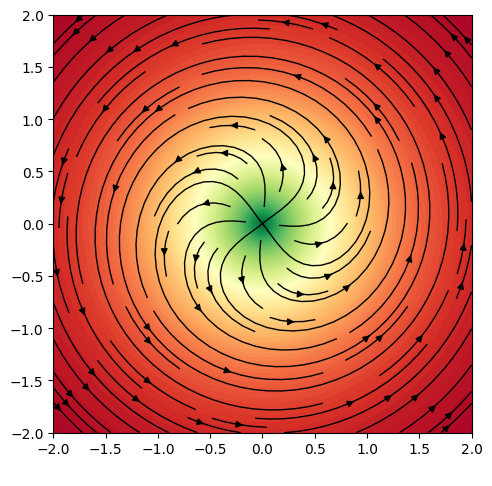

In [10]:
w = SPACE_SIZE
x, y = np.meshgrid(np.linspace(-w, w, 101), np.linspace(-w, w, 101))
u, v = wind_fn(x, y)
r = reward_fn(x, y)

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(-w, w)
ax.set_ylim(-w, w)
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_xlabel("x")
ax.xaxis.label.set_alpha(0.0)
ax.set_aspect("equal")


ax.contourf(x, y, r, levels=100, cmap="RdYlGn")
ax.streamplot(x, y, u, v, density=1, color="k", linewidth=1)

fig.tight_layout()
fig.savefig(fig_path / "wind_env.pdf")

In [11]:
class XYWindEnv(Environment):
    parameter_names = ["phi"]
    jittable_render = True

    def __init__(self, action_scale, space_size):
        super().__init__()
        self.max_action = 1.0
        self.action_scale = action_scale
        self.space_size = space_size

    def get_obs(self, state: EnvState) -> chex.Array:
        return jnp.array(state.pos)

    def action_space(self, params: Optional[EnvParams] = None) -> spaces.Box:
        return spaces.Box(low=-self.max_action, high=self.max_action, shape=(2,), dtype=jnp.float32)

    def observation_space(self, params: EnvParams) -> spaces.Box:
        """Observation space of the environment."""
        high = jnp.array([self.space_size], dtype=jnp.float32)
        return spaces.Box(-high, high, shape=(2,), dtype=jnp.float32)

    def state_space(self, params: Optional[EnvParams] = None) -> spaces.Box:
        return spaces.Dict(
            {
                "pos": spaces.Box(-jnp.finfo(jnp.float32).max, jnp.finfo(jnp.float32).max, (2), jnp.float32),
                "last_pos": spaces.Box(-jnp.finfo(jnp.float32).max, jnp.finfo(jnp.float32).max, (2), jnp.float32),
                "time": spaces.Discrete(params.max_steps_in_episode),
            }
        )

    def step_env(
        self, key: chex.PRNGKey, state: EnvState, action: float, params: EnvParams
    ) -> Tuple[chex.Array, EnvState, float, bool, dict]:
        action = jnp.clip(action, -self.max_action, self.max_action)
        action = self.action_scale * action

        reward = reward_fn(*state.pos)
        wind = jnp.stack(wind_fn(*state.pos))

        new_pos = state.pos + action + wind
        new_pos = jnp.clip(new_pos, -self.space_size, self.space_size)
        state = EnvState(new_pos, state.pos, state.time + 1)
        done = self.is_terminal(state, params)

        return (
            jax.lax.stop_gradient(self.get_obs(state)),
            jax.lax.stop_gradient(state),
            jax.lax.stop_gradient(reward),
            jax.lax.stop_gradient(done),
            {},
        )

    def reset_env(self, key: chex.PRNGKey, params: EnvParams) -> Tuple[chex.Array, EnvState]:
        # pos = jax.random.uniform(key, shape=(2,), minval=-self.space_size, maxval=self.space_size)
        pos = jnp.array([0.8, 0.0])
        state = EnvState(pos=pos, last_pos=pos, time=0)

        return jax.lax.stop_gradient(self.get_obs(state)), jax.lax.stop_gradient(state)

    def is_terminal(self, state: EnvState, params: EnvParams) -> bool:
        done = state.time >= params.max_steps_in_episode
        return done


In [12]:
def init_jax_runner_state(key):
    env, env_params = XYWindEnv(ACTION_SCALE, SPACE_SIZE), EnvParams(max_steps_in_episode=128)

    key, reset_key = jax.random.split(key)
    reset_keys = jax.random.split(reset_key, NUM_ENVS)
    observation, env_state = jax.vmap(
        env.reset,
        in_axes=(0, None),
    )(reset_keys, env_params)

    runner_state = RunnerState(
        env_state=env_state,
        observation=observation,
    )
    return runner_state, env, env_params, key


In [13]:
class Actor(nn.Module):
    @nn.compact
    def __call__(self, x):
        activation = nn.tanh
        x = nn.Dense(64, kernel_init=orthogonal(jnp.sqrt(2)), bias_init=constant(0.0))(x)
        x = activation(x)
        x = nn.Dense(64, kernel_init=orthogonal(jnp.sqrt(2)), bias_init=constant(0.0))(x)
        x = activation(x)
        x = nn.Dense(DIM_ACTION, kernel_init=orthogonal(0.01), bias_init=constant(0.0))(x)
        log_scale = self.param("log_scale", nn.initializers.constant(INIT_LOGSCALE), ())
        log_scale = jnp.clip(log_scale, MIN_LOGSCALE, 0.0)
        x = distrax.Normal(loc=x, scale=jnp.ones_like(x) * jnp.exp(log_scale))
        return x


def sample_action(d_action, key):
    key, action_key = jax.random.split(key)
    action = d_action.sample(seed=action_key)
    log_prob = d_action.log_prob(action)
    return action, log_prob, key


class Critic(nn.Module):
    @nn.compact
    def __call__(self, x):
        activation = nn.tanh
        x = nn.Dense(64, kernel_init=orthogonal(jnp.sqrt(2)), bias_init=constant(0.0))(x)
        x = activation(x)
        x = nn.Dense(64, kernel_init=orthogonal(jnp.sqrt(2)), bias_init=constant(0.0))(x)
        x = activation(x)
        x = nn.Dense(DIM_STATISTIC, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(x)
        if last is not None:
            x = last(x)
        return x


actor, critic = Actor(), Critic()

In [14]:
def linear_schedule(count):
    frac = 1.0 - (count // (NUM_MINIBATCHES * NUM_UPDATE_EPOCHS)) / NUM_UPDATES
    return LR * frac


def init_agent_state(init_observation, key):
    key, init_key = jax.random.split(key)
    actor_params = actor.init(init_key, init_observation)
    critic_params = critic.init(init_key, init_observation)

    tx = optax.chain(
        optax.clip_by_global_norm(MAX_GRAD_NORM),
        optax.adam(learning_rate=linear_schedule, eps=1e-5),
    )
    actor_state = TrainState.create(apply_fn=actor.apply, params=actor_params, tx=tx)
    critic_state = TrainState.create(apply_fn=critic.apply, params=critic_params, tx=tx)

    agent_state = AgentState(actor_state, critic_state)
    return agent_state, key


In [15]:
def jax_step(env, env_params, agent_state: AgentState, runner_state_key: Tuple[RunnerState, chex.PRNGKey]):
    # unpack
    actor_state, critic_state = agent_state
    (env_state, observation), key = runner_state_key

    # actor-critic
    d_action = actor.apply(actor_state.params, observation)
    action, log_prob, key = sample_action(d_action, key)
    statistic = critic.apply(critic_state.params, observation)
    value = post(statistic)

    # step
    key, step_key = jax.random.split(key)
    step_keys = jax.random.split(step_key, NUM_ENVS)
    next_observation, env_state, reward, done, info = jax.vmap(
        env.step,
        in_axes=(0, 0, 0, None),
    )(step_keys, env_state, action, env_params)

    # pack
    runner_state = RunnerState(env_state, next_observation)
    step = Step(observation, action, log_prob, done, reward, statistic, value, info)
    return (runner_state, key), step


In [16]:
def jax_trajectory(env, env_params, runner_state: RunnerState, agent_state: AgentState, key):
    (runner_state, key), trajectory = forward(
        f=ft.partial(jax_step, env, env_params, agent_state),
        init=(runner_state, key),
        length=NUM_STEPS,
    )
    return runner_state, trajectory, key


In [17]:
def update_statistic_with_termination(reward_done, statistic):
    reward, done = reward_done
    return update(reward, jnp.where(done[:, None], init, statistic))


def get_advantage(init, trajectory):
    advantage = post(
        scanr(
            f=update_statistic_with_termination,
            init=init,
            xs=(trajectory.reward, trajectory.done),
        )
    ) - trajectory.value
    return advantage


In [18]:
def actor_loss_fn(log_prob_pred, log_prob, advantage):
    # ratio = jnp.exp(log_prob_pred - log_prob)
    ratio = jnp.exp(jnp.sum(log_prob_pred - log_prob, axis=-1))
    ratio_clipped = jnp.clip(ratio, 1.0 - CLIP_EPS, 1.0 + CLIP_EPS)
    advantages = (advantage - advantage.mean()) / (advantage.std() + 1e-8)
    actor_loss = -jnp.minimum(ratio, ratio_clipped) * advantages
    actor_loss = actor_loss.mean()
    return actor_loss


def value_loss_fn(value_pred, value, target):
    value_clipped = value + (value_pred - value).clip(-CLIP_EPS, CLIP_EPS)
    value_losses = jnp.square(value_pred - target)
    value_losses_clipped = jnp.square(value_clipped - target)
    value_loss = 0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()
    return value_loss


def loss_fn(actor_params, critic_params, batch):
    trajectory, advantage = batch

    d_action = actor.apply(actor_params, trajectory.observation)
    log_prob = d_action.log_prob(trajectory.action)
    statistic = critic.apply(critic_params, trajectory.observation)
    value = post(statistic)

    actor_loss = actor_loss_fn(log_prob, trajectory.log_prob, advantage)
    value_loss = value_loss_fn(value, trajectory.value, advantage + trajectory.value)
    entropy = d_action.entropy().mean()
    loss = actor_loss + VF_COEF * value_loss - ENT_COEF * entropy
    return loss, LossInfo(loss, value_loss, actor_loss, entropy)


In [19]:
def prepare_minibatch(batch, key):
    # batch
    batch = jax.tree_util.tree_map(
        lambda x: x.reshape((BATCH_SIZE,) + x.shape[2:]),
        batch,
    )
    # shuffle
    key, permutation_key = jax.random.split(key)
    permutation = jax.random.permutation(permutation_key, BATCH_SIZE)
    shuffled_batch = jax.tree_util.tree_map(lambda x: jnp.take(x, permutation, axis=0), batch)
    # minibatch
    minibatches = jax.tree_util.tree_map(
        lambda x: jnp.reshape(x, [NUM_MINIBATCHES, -1] + list(x.shape[1:])),
        shuffled_batch,
    )
    return minibatches, key


def update_agent(agent_state, minibatch):
    actor_state, critic_state = agent_state

    # gradient
    grad_fn = jax.grad(loss_fn, argnums=[0, 1], has_aux=True)
    (actor_grads, critic_grads), loss_info = grad_fn(actor_state.params, critic_state.params, minibatch)
    # update
    actor_state = actor_state.apply_gradients(grads=actor_grads)
    critic_state = critic_state.apply_gradients(grads=critic_grads)

    return AgentState(actor_state, critic_state), loss_info


def update_step(trajectory_fn, update_state_key):
    runner_state, agent_state, key = update_state_key

    runner_state, trajectory, key = trajectory_fn(runner_state, agent_state, key)
    last_statistic = critic.apply(agent_state.critic_state.params, runner_state.observation)
    advantage = get_advantage(last_statistic, trajectory)
    batch = Batch(trajectory, advantage)
    minibatches, key = prepare_minibatch(batch, key)
    agent_state, loss_info = forward(
        f=lambda agent_state: jax.lax.scan(
            f=update_agent,
            init=agent_state,
            xs=minibatches,
        ),
        init=agent_state,
        length=NUM_UPDATE_EPOCHS,
    )
    return (runner_state, agent_state, key), loss_info


In [20]:
def jax_train(runner_state, agent_state, trajectory_fn, key):
    (runner_state, agent_state, key), loss_info = forward(
        f=ft.partial(update_step, trajectory_fn),
        init=(runner_state, agent_state, key),
        length=NUM_UPDATES,
    )
    return runner_state, agent_state, loss_info, key


In [21]:
key = jax.random.PRNGKey(42)

runner_state, env, env_params, key = init_jax_runner_state(key)
agent_state, key = init_agent_state(runner_state.observation, key)
trajectory_fn = ft.partial(jax_trajectory, env, env_params)
runner_state, agent_state, loss_info, key = jax_train(runner_state, agent_state, trajectory_fn, key)


In [22]:
def render(space_size, state: EnvState) -> jax.Array:
    size = 256
    radius = 5
    rgb_array = jnp.full([size, size, 3], 64, dtype=jnp.uint8)

    def draw_circle(edit_array, pos, radius, color):
        color = jnp.array(color, dtype=jnp.uint8)
        color = jnp.tile(color, [256, 256, 1])
        pos = (pos + space_size) / (2 * space_size) * size
        y, x = jnp.mgrid[:size, :size]
        y_diff = y - pos[0]
        x_diff = x - pos[1]
        pixel_dists = jnp.sqrt(x_diff**2 + y_diff**2)
        pixel_dists = jnp.repeat(pixel_dists[:, :, None], 3, 2)
        return jnp.where(pixel_dists < radius, color, edit_array)

    rgb_array = draw_circle(rgb_array, state.last_pos, radius, [0, 125, 0])
    rgb_array = draw_circle(rgb_array, state.pos, radius, [0, 255, 0])
    rgb_array = draw_circle(rgb_array, jnp.array([0, 0]), radius, [0, 0, 255])

    return rgb_array


def vis(actor_state):
    vis_env = XYWindEnv(ACTION_SCALE, SPACE_SIZE)
    key = jax.random.PRNGKey(42)
    key, reset_key = jax.random.split(key)
    observation, env_state = vis_env.reset(reset_key)
    rewards = []
    positions = []
    images = []
    for _ in range(101):
        key, act_key, step_key = jax.random.split(key, 3)
        action = actor.apply(actor_state.params, observation).sample(seed=act_key)
        observation, env_state, reward, done, info = vis_env.step(step_key, env_state, action, env_params)
        rewards.append(reward)
        positions.append(env_state.pos)
        images.append(render(SPACE_SIZE, env_state))
    return rewards, np.stack(positions), images


In [23]:
rewards, positions, images = vis(agent_state.actor_state)

jnp.save(data_path / f"rewards_{name}.npy", rewards)
jnp.save(data_path / f"positions_{name}.npy", positions)


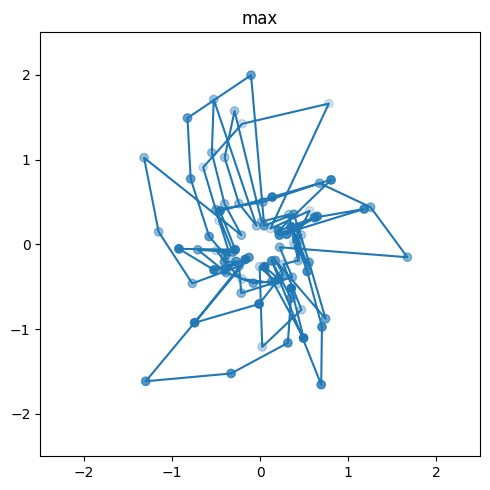

In [24]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title(name)
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)

ax.plot(*positions.T)
ax.scatter(*positions.T, alpha=np.linspace(0.1, 1.0, len(positions)))

fig.tight_layout()

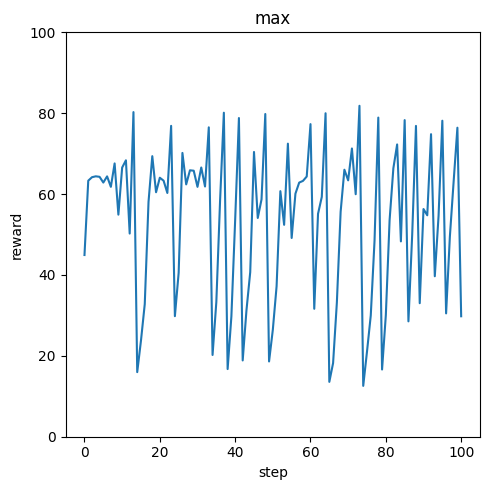

In [25]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title(name)
ax.set_xlabel("step")
ax.set_ylabel("reward")
ax.set_ylim(0, 100)

ax.plot(rewards)

fig.tight_layout()

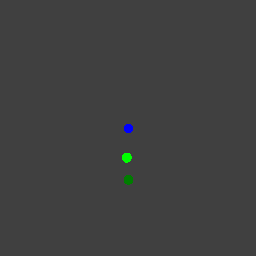

In [26]:
import imageio
from IPython.display import Image


gif_path = fig_path / f"wind_{name}.gif"
imageio.mimsave(gif_path, images, loop=0)
Image(filename=gif_path)